In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

In [2]:
test = pd.read_csv('raw/test.csv')
test.head(1)

,ID,shop_id,item_id
0,0,5,5037


In [3]:
sample_submission = pd.read_csv('raw/sample_submission.csv')
sample_submission.head(1)

,ID,item_cnt_month
0,0,0.5


In [4]:
test.count()

ID         214200
shop_id    214200
item_id    214200
dtype: int64

In [5]:
sample_submission.count()

ID                214200
item_cnt_month    214200
dtype: int64

In [6]:
train = pd.read_csv('raw/sales_train.csv')
train['date'] = pd.to_datetime(train['date'])
train.head(2)
# TODO: exclude date leaks

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.0,1.0
1,2013-03-01,0,25,2552,899.0,1.0


In [7]:
def forecast_as_all_time_average(trn, forecast_month_length, ):
    forecast = (trn
        .groupby(['item_id', 'shop_id'],
                as_index=False)
        .agg({'item_cnt_day': ['sum', 'count'],
              'date': ['min', 'max']})
    )
    forecast['sale_days'] = (forecast['date']['max']-forecast['date']['min']).dt.days + 1
    forecast['avg_daily_sale_items'] = forecast['item_cnt_day']['sum'] / forecast['sale_days']
    # TODO: wouldn't it be better to split daily forecasting and monthly aggs into like separate things to experiment?
    forecast = pd.DataFrame({
        'item_id': forecast['item_id'],
        'shop_id': forecast['shop_id'],
        'item_cnt_month': forecast['avg_daily_sale_items']*forecast_month_length
    })
    return forecast

In [8]:
example = pd.DataFrame(
    columns=['date', 'item_id', 'shop_id', 'item_cnt_day'],
    data=[
        ['2010-01-01', 1, 1, 2],
        ['2010-01-01', 1, 2, 3],
        ['2010-01-01', 2, 1, 1],
        ['2010-01-01', 3, 1, 1],
        ['2010-01-06', 3, 1, 2],
    ]
)
example['date'] = pd.to_datetime(example['date'])

# TODO: wrap that in proper test ids
forecast = forecast_as_all_time_average(example, forecast_month_length=30)
forecast

,item_id,shop_id,item_cnt_month
0,1,1,60.0
1,1,2,90.0
2,2,1,30.0
3,3,1,15.0


In [9]:
assert 60 == forecast.query('item_id == 1 and shop_id == 1')['item_cnt_month'].values[0]
assert 90 == forecast.query('item_id == 1 and shop_id == 2')['item_cnt_month'].values[0]
assert 30 == forecast.query('item_id == 2 and shop_id == 1')['item_cnt_month'].values[0]
assert 15 == forecast.query('item_id == 3 and shop_id == 1')['item_cnt_month'].values[0]

In [10]:
train_forecast = forecast_as_all_time_average(train, 30)

In [11]:
def forecast_to_submission(forecast):
    submission = test.merge(forecast, on=['item_id', 'shop_id'], how='left')
    assert len(test) == len(submission), (f"Generated submission length({len(submission)})" +
     f" doesn't match to expected submission length ({len(test)})")
    submission.fillna(0, inplace=True)
    submission.drop(['shop_id', 'item_id'], axis=1, inplace=True)
    return submission

submission = forecast_to_submission(train_forecast)

In [12]:
!mkdir -p submissions

In [13]:
submission.to_csv('submissions/submission_0001_avg_future_unfiltered.csv', index=False)

In [47]:
# Score: 11.15418
!head -n2 submissions/submission_0001_avg_future_unfiltered.csv

ID,item_cnt_month
0,1.1304347826086958


<AxesSubplot:>

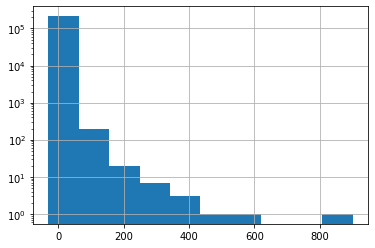

In [48]:
submission['item_cnt_month'].hist(log=True)

In [43]:
target_forecast_start = pd.to_datetime('2015-11-01')
train_no_future = train.query('date < @target_forecast_start')
forecast = forecast_as_all_time_average(train_no_future, forecast_month_length=30)
submission = forecast_to_submission(forecast)
submission.to_csv('submissions/submission_0002_avg_future_train_removed.csv', index=False)

In [44]:
# Score: 11.22965 (worse, than unfiltered, sort of confirms some of the train data is leak from the test)
!head -n2 submissions/submission_0002*.csv

ID,item_cnt_month
0,1.1304347826086958


<AxesSubplot:>

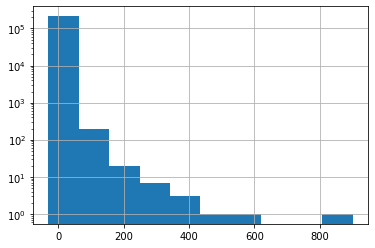

In [49]:
submission['item_cnt_month'].hist(log=True)

In [56]:
def forecast_last_average(trn, forecast_month_length, train_interval_len, target_forecast_start):
    target_forecast_start = pd.to_datetime(target_forecast_start)
    tmp = trn.copy()
    tmp['days_before_target'] = (target_forecast_start - tmp['date']).dt.days
    tmp = tmp.query('days_before_target > 0 and days_before_target < @train_interval_len')

    forecast = (tmp
        .groupby(['item_id', 'shop_id'],
                as_index=False)
        .agg({'item_cnt_day': ['sum', 'count'],
              'date': ['min', 'max']})
    )
    forecast['sale_days'] = (forecast['date']['max']-forecast['date']['min']).dt.days + 1
    forecast['avg_daily_sale_items'] = forecast['item_cnt_day']['sum'] / train_interval_len

    forecast = pd.DataFrame({
        'item_id': forecast['item_id'],
        'shop_id': forecast['shop_id'],
        'item_cnt_month': forecast['avg_daily_sale_items']*forecast_month_length
    })
    return forecast

In [57]:
example = pd.DataFrame(
    columns=['date', 'item_id', 'shop_id', 'item_cnt_day'],
    data=[
        ['2010-01-01', 1, 1, 2],
        ['2010-01-01', 1, 2, 3],
        ['2010-01-01', 2, 1, 1],
        ['2010-01-01', 3, 1, 1],
        ['2010-01-06', 3, 1, 2],
    ]
)
example['date'] = pd.to_datetime(example['date'])

forecast = forecast_last_average(example,
                                forecast_month_length=1,
                                train_interval_len=4,
                                target_forecast_start='2010-01-07')
forecast

,item_id,shop_id,item_cnt_month
0,3,1,0.5


In [58]:
assert 0.5 == forecast.query('item_id == 3 and shop_id == 1')['item_cnt_month'].values[0]
assert 1  == len(forecast)

In [59]:
target_forecast_start = pd.to_datetime('2015-11-01')
train_no_future = train.query('date < @target_forecast_start')
forecast = forecast_last_average(train_no_future,
                                 forecast_month_length=30,
                                 train_interval_len=30,
                                 target_forecast_start=target_forecast_start)
submission = forecast_to_submission(forecast)
submission.to_csv('submissions/submission_0003_avg_last_mo.csv', index=False)

In [50]:
# Score: 8.42181, last month represents the next one much better than overall avg history
!head -n5 submissions/submission_0003*.csv

ID,item_cnt_month
0,0.0
1,0.0
2,0.0
3,0.0


<AxesSubplot:>

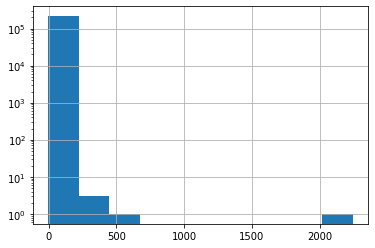

In [65]:
# this looks much more depressive vs prev subs but also closer to the truth
submission['item_cnt_month'].hist(log=True)

In [52]:
len(forecast)

422578

In [64]:
submission['item_cnt_month'].value_counts()

0.0      187331
1.0       18662
2.0        4423
3.0        1583
4.0         756
          ...  
421.0         1
115.0         1
37.0          1
77.0          1
78.0          1
Name: item_cnt_month, Length: 78, dtype: int64